In [18]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



In [19]:
sample_docs = [
    ("Bài luận 1", "Trí tuệ nhân tạo đang phát triển nhanh chóng và tác động lớn đến cuộc sống.") ,
    ("Bài luận 2", "Trí tuệ nhân tạo đang phát triển mạnh mẽ và ảnh hưởng nhiều đến đời sống con người.") ,
    ("Bài luận 3", "Trí tuệ nhân tạo rất mạnh mẽ và ảnh hưởng nhiều đến đời sống con người.") ,
    ("Bài luận 4", " Deep Learning đã mang lại những bước tiến vượt bậc trong lĩnh vực xử lý ngôn ngữ tự nhiên.") ,
    ("Bài luận 5", " Robotics và tự động hóa đang thay đổi cách chúng ta làm việc trong các nhà máy.") ,
    ("Bài luận 6", " Internet of Things kết nối hàng tỷ thiết bị thông minh trên toàn cầu"),
     ("Bài luận 7", " Blockchain không chỉ dùng cho tiền điện tử mà còn nhiều ứng dụng khác.") ,
     ("Bài luận 8", " Cloud Computing giúp doanh nghiệp tiết kiệm chi phí và tăng hiệu quả.") ,
     ("Bài luận 9", "Bảo mật thông tin là thách thức lớn trong kỷ nguyên số.") ,
     ("Bài luận 10", "5G sẽ tạo ra cuộc cách mạng trong truyền thông di động.")
]


In [20]:
# Preprocessing data
def clean_data(data):
    data = [sample[1] for sample in data]
    data = [sample.lower() for sample in data]
    return data

def create_vocab(data):
    vocab = [word
             for sample in data
             for word in re.split(r'[,\.\s]+',sample)
             if word]
    return set(sorted(vocab))


def compute_tf(word, sample):
    return sample.count(word) / len(sample)


def compute_idf(word, data):
    numerator = len(data)
    count = 0
    for sample in data:
        if word in sample:
            count += 1
    return np.log(numerator / (1+ count))

def compute_tf_idf(word, sample, data):
    tf = compute_tf(word, sample)
    idf = compute_idf(word, data)
    return float(tf) * float(idf)

def create_matrix_tf_idf(vocab,data):
    matrix = []
    for sample in data:
        row = []
        for word in vocab:
            row.append(compute_tf_idf(word, sample, data))
        matrix.append(row)
    return matrix


def compute_cosine_similarity(vector1, vector2):
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    numerator = np.dot(vector1, vector2)
    denomiantor = np.sqrt(np.sum(np.dot(vector1,vector1)))*np.sqrt(np.sum(np.dot(vector2,vector2)))
    cosine_similarity = numerator/denomiantor
    return cosine_similarity


def compute_cosine_similarity_matrix(matrix):
    similarity_matrix = []
    for i in range(len(matrix)):
        row = []
        for j in range(len(matrix)):
            row.append(compute_cosine_similarity(matrix[i],matrix[j]))
        similarity_matrix.append(row)
    return similarity_matrix


def plot_heatmap(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='YlGnBu', vmin=0, vmax=1, fmt=".2f",xticklabels=labels, yticklabels=labels)
    plt.title("Cosine Similarity Between Documents", fontsize=14, color='blue')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()




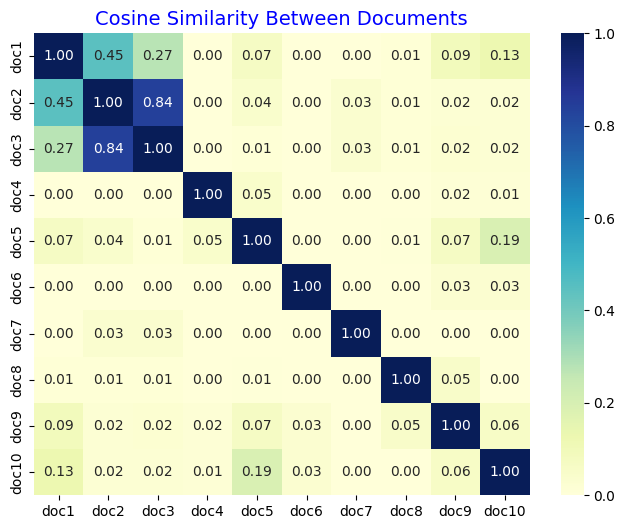

In [21]:
#Document names
doc_names = ['doc1', 'doc2', 'doc3', 'doc4', 'doc5', 'doc6', 'doc7', 'doc8', 'doc9', 'doc10']
# Preprocessing data
data = clean_data(sample_docs)

# Create vocabulary
vocab = create_vocab(data)

# Create matrix tf-idf
matrix = create_matrix_tf_idf(vocab,data)

# Compute cosine similarity matrix
similarity_matrix = compute_cosine_similarity_matrix(matrix)

# Plot heatmap
plot_heatmap(similarity_matrix, doc_names)




In [22]:
# Connect to database
import mysql.connector
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="123#edc",
    database="aio.week8",
    auth_plugin='caching_sha2_password'
)

print("Connected!")
# Create cursor
cursor = connection.cursor()

# Create table
cursor.execute("""
CREATE TABLE IF NOT EXISTS documents (
               doc_id INT AUTO_INCREMENT PRIMARY KEY,
               title VARCHAR(255),
               content TEXT,
               upload_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
               last_modified TIMESTAMP DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP
               );
               """)

cursor.execute("""
CREATE TABLE IF NOT EXISTS similarity_scores (
               score_id INT AUTO_INCREMENT PRIMARY KEY,
               doc1_id INT,
               doc2_id INT,
               similarity_score FLOAT,
               check_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
               FOREIGN KEY (doc1_id) REFERENCES documents(doc_id),
               FOREIGN KEY (doc2_id) REFERENCES documents(doc_id)
               );
               """)

cursor.execute("""
CREATE TABLE IF NOT EXISTS plagiarism_reports (
               report_id INT AUTO_INCREMENT PRIMARY KEY,
               doc_id INT,
               report_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
               status ENUM('pending', 'reviewed', 'confirmed', 'rejected'),
               review_notes TEXT,
               FOREIGN KEY (doc_id) REFERENCES documents(doc_id)
               );
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS document_metadata (
               metadata_id INT AUTO_INCREMENT PRIMARY KEY,
               doc_id INT,
               word_count INT,
               language VARCHAR(50),
               category VARCHAR(100),
               keywords TEXT,
               FOREIGN KEY (doc_id) REFERENCES documents(doc_id)
               );
               """)



Connected!


In [23]:
connection.commit()
cursor.close()
connection.close()

In [24]:
import mysql.connector
from mysql.connector import Error

def create_mysql_connection(
    host='localhost',
    user='root',
    password='123#edc',
    database='aio.week8',
    auth_plugin='caching_sha2_password'
):
    """
    Kết nối đến MySQL và trả về đối tượng connection.
    Trả về None nếu xảy ra lỗi.
    """
    try:
        conn = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database,
            auth_plugin=auth_plugin
        )
        if conn.is_connected():
            print("✅ Đã kết nối tới MySQL.")
            return conn
    except Error as e:
        print("❌ Kết nối thất bại:", e)
        return None


In [31]:
def save_documents_list_to_mysql(connection, documents):
    """
    Lưu danh sách văn bản vào bảng 'documents'.

    Args:
        connection: kết nối MySQL
        documents (list): danh sách các [title, content]
    
    Returns:
        Số lượng văn bản lưu thành công
    """
    try:
        cursor = connection.cursor()
        sql = """
            INSERT INTO documents (title, content)
            VALUES (%s, %s)
        """
        cursor.executemany(sql, documents)
        connection.commit()
        print(f"✅ Đã lưu {cursor.rowcount} văn bản vào MySQL.")
        return cursor.rowcount
    except mysql.connector.Error as e:
        print("❌ Lỗi khi lưu danh sách văn bản:", e)
        return 0


In [27]:
conn = create_mysql_connection()

if conn:
    save_documents_list_to_mysql(conn, sample_docs)
    conn.close()


✅ Đã kết nối tới MySQL.
✅ Đã lưu 10 văn bản vào MySQL.


In [52]:
def save_cosine_similarity_to_mysql(connection, similarity_matrix, doc_pairs):
    """
    Lưu danh sách văn bản vào bảng 'similarity_scores'.

    Args:
        connection: kết nối MySQL
        similarity_scores (list): danh sách các [doc1_id, doc2_id, similarity_score]
    
    Returns:
        Số lượng văn bản lưu thành công
    """
    try:
        length = min(len(doc_pairs), len(similarity_matrix))
        data = [
        (doc_pairs[i][0], doc_pairs[i][1], float(similarity_matrix[i][0]))
        for i in range(length)
        if similarity_matrix[i] and isinstance(similarity_matrix[i][0], (int, float))
                ]
        cursor = connection.cursor()
        sql = """
            INSERT INTO similarity_scores (doc1_id, doc2_id, similarity_score)
            VALUES (%s, %s, %s)
        """
        cursor.executemany(sql,data)
        connection.commit()
        print(f"✅ Đã lưu {cursor.rowcount} văn bản vào MySQL.")
        return cursor.rowcount
    except mysql.connector.Error as e:
        print("❌ Lỗi khi lưu danh sách văn bản:", e)
        return 0

def get_all_document_ids(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT doc_id FROM documents ORDER BY doc_id")
    result = cursor.fetchall()
    return [row[0] for row in result]  # Trả về list các doc_id


def generate_unique_doc_pairs(doc_ids):
    pairs = []
    n = len(doc_ids)
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append((doc_ids[i], doc_ids[j]))
    return pairs




In [53]:
conn = create_mysql_connection()

if conn:
    doc_ids = get_all_document_ids(conn)

    doc_pairs = generate_unique_doc_pairs(doc_ids)

    save_cosine_similarity_to_mysql(conn, similarity_matrix, doc_pairs)

    conn.close()



✅ Đã kết nối tới MySQL.
✅ Đã lưu 10 văn bản vào MySQL.
